In [1]:

import sys
import os
import argparse

import subprocess
import psycopg2 as pg
import pandas.io.sql as psql

import pandas as pd
import numpy as np
from io import StringIO
from dateutil import tz
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min

In [82]:
def get_hourly_data():
    try:
        connection = pg.connect("host=localhost dbname=traffic user=postgres password=1234")
        df = psql.read_sql("select * from public.hourly;",connection)
        return df
    except (Exception, pg.Error) as error:
        print("Error while fetching data from PostgreSQL", error)
    finally:
        # closing database connection.
        if connection:
            connection.close()
            print("PostgreSQL connection is closed")
orig_df = get_hourly_data()
# orig_df = pd.read_csv('hourly.csv')

orig_df = orig_df.drop(columns = 'cluster_num')
orig_df = orig_df.dropna()
df = orig_df.drop(columns = 'osm_way_id')
print(df.head())
print(df.shape)

PostgreSQL connection is closed
        hour0      hour1      hour2      hour3      hour4      hour5  \
0   26.305741  25.349394  25.255238  24.821519  24.136204  23.589649   
5   35.260313  37.106141  37.652427  37.477883  37.337509  36.999126   
7   37.565158  36.202676  35.867714  34.696579  34.250949  35.081571   
9   24.605367  24.489386  24.361795  23.581164  22.682313  22.363853   
12  38.574079  37.401638  36.950242  36.689310  35.615036  35.900669   

        hour6      hour7      hour8      hour9  ...  std_dev_14  std_dev_15  \
0   22.908557  22.811266  22.948332  22.672122  ...   14.742326   14.825014   
5   37.057193  36.192891  35.200139  33.822797  ...   11.392212   10.872726   
7   34.759567  33.992688  33.088739  31.164948  ...   13.950924   13.880063   
9   22.090231  22.460020  22.977684  23.523079  ...   15.117590   15.071607   
12  35.648769  35.806796  36.347455  37.443707  ...   13.355571   13.171204   

    std_dev_16  std_dev_17  std_dev_18  std_dev_19  std_dev_

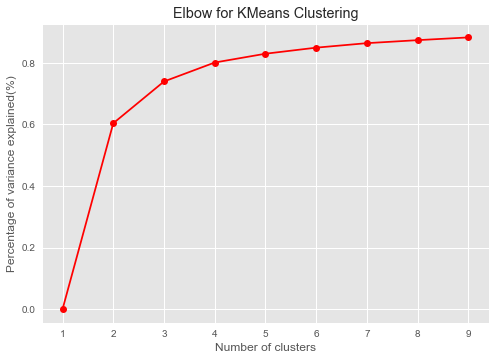

In [83]:
def elbow(df, n):
    kMeansVar = [KMeans(n_clusters=k).fit(df.values) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df.values)**2)/df.values.shape[0]
    bss = (tss - wcss)/tss
    x_vals = list(range(1,1+len(bss)))
    plt.plot(x_vals,bss,color='red', marker="o")
    plt.grid(True)
    plt.title('Elbow for KMeans Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained(%)')
    plt.show()

elbow(df,10)

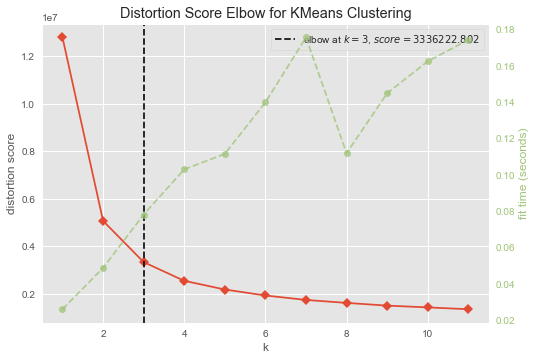

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [85]:

kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, df)
# Save the labels
df.loc[:,'labels'] = kmeans.labels_
orig_df.loc[:,'labels'] = kmeans.labels_
print(closest)

[[24.35086559 24.2705815  24.17007991 23.92257846 23.62794997 23.49578428
  23.35162588 23.10830024 22.86090477 22.4626122  22.06114659 22.08446497
  22.68960096 24.15073689 25.56474269 26.85054015 27.62591801 28.09668572
  28.47202487 28.61414304 28.79724141 28.69638153 27.31037554 25.4469899
  12.21012208 12.31230339 12.26884191 12.44185247 12.55753476 12.60300451
  12.62160563 12.63564931 12.74622647 13.0334563  13.20968355 13.05611542
  12.52258072 12.20772924 11.79894831 11.59586704 11.39168505 11.2493168
  11.21247067 10.86357833 11.12998666 11.14145427 11.04517549 11.8652354 ]
 [64.03905337 63.73081624 63.95451953 63.83789103 63.68199978 63.60850135
  63.64066598 63.52661794 63.001225   61.84880901 60.13336035 58.56262118
  58.73346001 61.40422396 63.61775516 65.20009132 66.09026764 66.44275472
  66.90805124 66.76137451 67.0121518  67.47482    66.90828545 65.53752247
  14.96167672 14.90586113 14.67493225 14.64815323 14.64103829 14.56966423
  14.66423859 14.84347728 14.91755945 1

In [86]:
# print(len(df) )
df_ = orig_df.values
center_way_ids = []
for i in range(len(closest)):
    print(f"Cluster {i+1} center: {int(df_[closest[i]][0])}")
    print(df_[closest[i]])
    center_way_ids.append(int(df_[closest[i]][0]))
    

Cluster 1 center: 529987013
[5.29987013e+08 2.49595964e+01 2.44549991e+01 2.43081938e+01
 2.39872172e+01 2.35416962e+01 2.33220146e+01 2.31809974e+01
 2.29581403e+01 2.28026460e+01 2.23623184e+01 2.18363392e+01
 2.18382485e+01 2.24969203e+01 2.39615420e+01 2.50852118e+01
 2.59966844e+01 2.66798664e+01 2.69952371e+01 2.77260588e+01
 2.79131319e+01 2.79069536e+01 2.85167699e+01 2.82193408e+01
 2.65844297e+01 1.21108159e+01 1.25047154e+01 1.22447162e+01
 1.22920216e+01 1.21288920e+01 1.23021697e+01 1.25285494e+01
 1.25997197e+01 1.27723276e+01 1.32067902e+01 1.32289477e+01
 1.27667597e+01 1.21981553e+01 1.20341379e+01 1.17913068e+01
 1.11970844e+01 1.12564208e+01 1.05326917e+01 1.10088464e+01
 1.11185022e+01 1.07863533e+01 1.14105434e+01 1.16883668e+01
 1.19819864e+01 0.00000000e+00]
Cluster 2 center: 4962952
[4.96295200e+06 6.36476474e+01 6.34241772e+01 6.36704282e+01
 6.29844504e+01 6.30410565e+01 6.31455537e+01 6.25062810e+01
 6.28732755e+01 6.29074986e+01 6.25233994e+01 6.23884353e+01

In [87]:
def get_hourly_data():
    try:
        connection = pg.connect("host=localhost dbname=traffic user=postgres password=1234")
        center_id_str = ','.join(map(str,center_way_ids))
        sql_query = """SELECT osm_way_id,
                 FLOOR(EXTRACT(HOUR FROM utc_timestamp)) AS hour_num ,
                 speed.AVG AS hour_speed
                 FROM public.speed
                 WHERE osm_way_id in (""" + center_id_str + ")"
        print(sql_query)
        df = psql.read_sql(sql_query,connection)
        return df
    except (Exception, pg.Error) as error:
        print("Error while fetching data from PostgreSQL", error)
    finally:
        # closing database connection.
        if connection:
            connection.close()
            print("PostgreSQL connection is closed")
    
cdf = get_hourly_data()
cdf.head()

SELECT osm_way_id,
                 FLOOR(EXTRACT(HOUR FROM utc_timestamp)) AS hour_num ,
                 speed.AVG AS hour_speed
                 FROM public.speed
                 WHERE osm_way_id in (529987013,4962952,678652462)
PostgreSQL connection is closed


,osm_way_id,hour_num,hour_speed
0,678652462.0,2.0,47.683
1,678652462.0,18.0,40.787
2,678652462.0,5.0,40.399
3,678652462.0,10.0,39.585
4,678652462.0,22.0,37.862


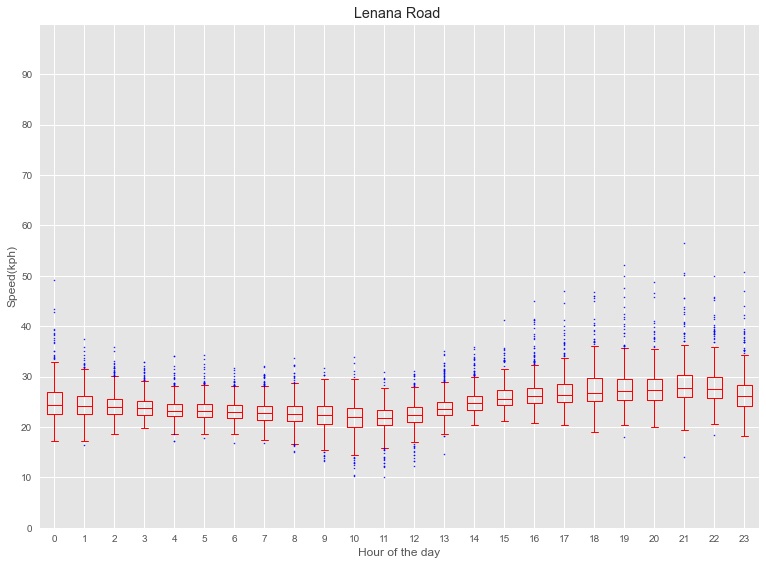

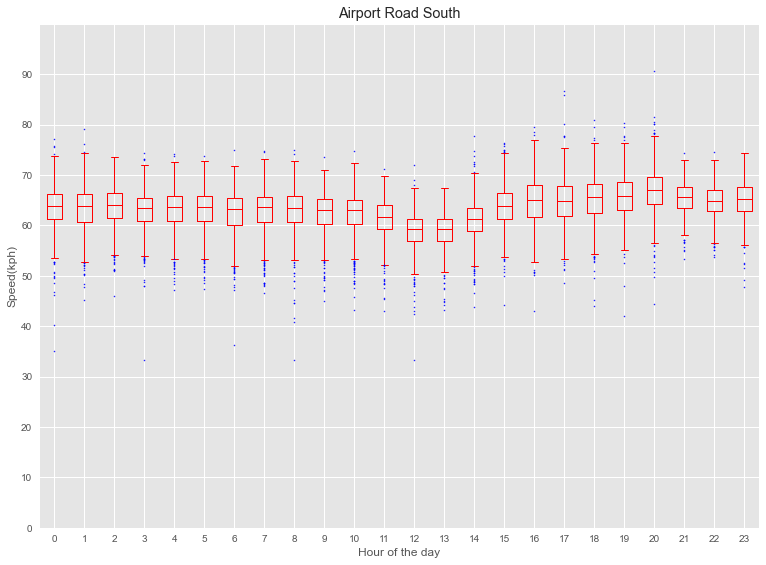

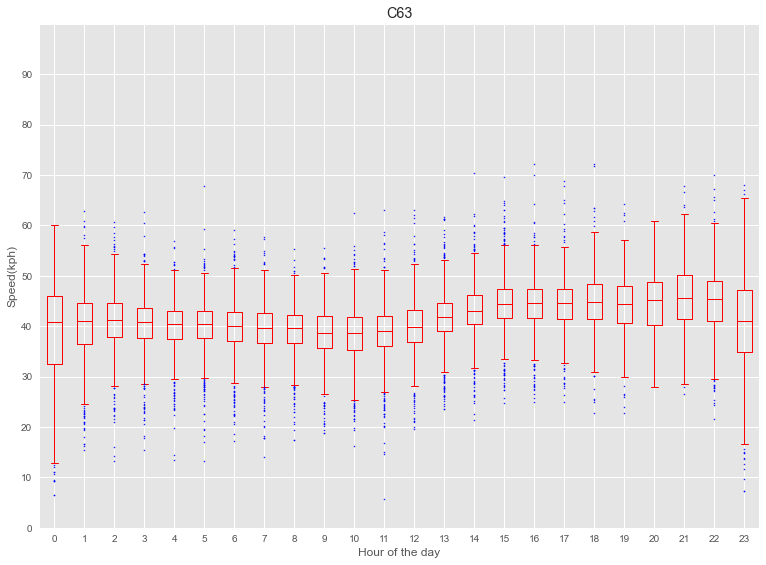

In [88]:
plt.style.use('ggplot')
address = {321619722: 'Kasarani Mwiki Road',
           4962952:'Airport Road South ',
           321619710:'Thika Road ',
          529987013: 'Lenana Road ',
         4962952: 'Airport Road South',
        678652462:'C63'  }
def plotBox(cdf,wayId):
    df_ = cdf[cdf['osm_way_id']==wayId]
    data_00 = df_[df_['hour_num']==0]['hour_speed']
    data_01 = df_[df_['hour_num']==1]['hour_speed']
    data_02 = df_[df_['hour_num']==2]['hour_speed']
    data_03 = df_[df_['hour_num']==3]['hour_speed']
    data_04 = df_[df_['hour_num']==4]['hour_speed']
    data_05 = df_[df_['hour_num']==5]['hour_speed']
    data_06 = df_[df_['hour_num']==6]['hour_speed']
    data_07 = df_[df_['hour_num']==7]['hour_speed']
    data_08 = df_[df_['hour_num']==8]['hour_speed']
    data_09 = df_[df_['hour_num']==9]['hour_speed']
    data_10 = df_[df_['hour_num']==10]['hour_speed']
    data_11 = df_[df_['hour_num']==11]['hour_speed']
    data_12 = df_[df_['hour_num']==12]['hour_speed']
    data_13 = df_[df_['hour_num']==13]['hour_speed']
    data_14 = df_[df_['hour_num']==14]['hour_speed']
    data_15 = df_[df_['hour_num']==15]['hour_speed']
    data_16 = df_[df_['hour_num']==16]['hour_speed']
    data_17 = df_[df_['hour_num']==17]['hour_speed']
    data_18 = df_[df_['hour_num']==18]['hour_speed']
    data_19 = df_[df_['hour_num']==19]['hour_speed']
    data_20 = df_[df_['hour_num']==20]['hour_speed']
    data_21 = df_[df_['hour_num']==21]['hour_speed']
    data_22 = df_[df_['hour_num']==22]['hour_speed']
    data_23 = df_[df_['hour_num']==23]['hour_speed']
    data = [data_00,data_01,data_02,data_03,data_04,data_05,data_06,data_07,data_08,data_09,data_10,data_11,data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21,data_22,data_23]


    fig = plt.figure(figsize =(10, 7))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    # Creating plot
    flierprops = dict(marker='.', markerfacecolor='blue', markersize=1,
                  linestyle='none', markeredgecolor='blue')
    bp = ax.boxplot(data,flierprops=flierprops)
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='red')
    # show plot
    plt.ylim(0,100)
    plt.yticks(np.arange(0, 100,10))
    plt.xlabel('Hour of the day')
    plt.ylabel('Speed(kph)')
    plt.title(address[wayId])
    
    plt.show()
for i in center_way_ids:
    plotBox(cdf,i)

In [89]:
# saving label to hourly table

# from psycopg2.extensions import register_adapter, AsIs
# def addapt_numpy_float64(numpy_float64):
#     return AsIs(numpy_float64)

# def addapt_numpy_int64(numpy_int64):
#     return AsIs(numpy_int64)

# def addapt_numpy_float32(numpy_float32):
#     return AsIs(numpy_float32)

# def addapt_numpy_int32(numpy_int32):
#     return AsIs(numpy_int32)

# def addapt_numpy_array(numpy_array):
#     return AsIs(tuple(numpy_array))

# register_adapter(np.float64, addapt_numpy_float64)
# register_adapter(np.int64, addapt_numpy_int64)
# register_adapter(np.float32, addapt_numpy_float32)
# register_adapter(np.int32, addapt_numpy_int32)
# register_adapter(np.ndarray, addapt_numpy_array)

way_id_labels_records = orig_df[['labels','osm_way_id']].to_records(index=False)
print(way_id_labels_records)
print(type(way_id_labels_records[0][1]))
def update_hourly_table(records):
    try:
        connection = pg.connect("host=localhost dbname=traffic user=postgres password=1234")
        cursor = connection.cursor()
        sql_update_query = """UPDATE public.hourly
        SET cluster_num = %s
        WHERE osm_way_id = %s;"""
        print(records[0])
        cursor.executemany(sql_update_query, records)
        # cursor.exec(cursor,sql_update_query, records[0][0])
        connection.commit()
        row_count = cursor.rowcount
        print(row_count, "Records Updated")
    except (Exception, pg.Error) as error:
        print("Error while updating PostgreSQL table", error)

    finally:
        # closing database connection.
        if connection:
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")    

update_hourly_table(way_id_labels_records)


[(0, 4.71685900e+06) (2, 4.71686000e+06) (2, 4.71686200e+06) ...
 (0, 6.87425392e+08) (0, 6.87425393e+08) (2, 6.98498913e+08)]
<class 'numpy.float64'>
(0, 4716859.)
2101 Records Updated
PostgreSQL connection is closed
